# Dermatologist AI

### 1. Resize all the Images in Dataset

In [1]:
from PIL import Image
import os

def img_resize(path, new_path, size):
    subfolders = [f.name for f in os.scandir(path) if f.is_dir() ]
    for i in subfolders:
        read_from_path = path + '/' + i + '/'
        write_to_path = new_path + '/' + i + '/'
        if not os.path.exists(write_to_path):
            os.makedirs(write_to_path)
        for f in (os.listdir(read_from_path)):
            source_image_name = read_from_path + f
            dest_image_name = write_to_path + f
            img = Image.open(source_image_name)
            img = img.resize(size)
            img.save(dest_image_name)
            

In [2]:
# Resizing all images to this size
size = (150, 150)

# Path to original dataset
train_data_dir = 'data/train'
valid_data_dir = 'data/valid'
test_data_dir = 'data/test'

# Path to place resized images of the dataset.
train_data_dir_resized = 'resized_data/train'
valid_data_dir_resized = 'resized_data/valid'
test_data_dir_resized = 'resized_data/test'

# Resize train images
img_resize(train_data_dir, train_data_dir_resized, size)
# Resize validation images
img_resize(valid_data_dir, valid_data_dir_resized, size)
# Resize test images
img_resize(test_data_dir, test_data_dir_resized, size)

### 2. Load Dataset (Resized Images)

In [1]:
# Path to place resized images of the dataset.
train_data_dir_resized = 'resized_data/train'
valid_data_dir_resized = 'resized_data/valid'
test_data_dir_resized = 'resized_data/test'

from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np
            
# Define a function to load train, test and validation dataset
def load_dataset(path):
    data = load_files(path)
    skin_files = np.array(data['filenames'])
    skin_targets = np_utils.to_categorical(np.array(data['target']), 3)
    return skin_files, skin_targets

# Load train, test, validation dataset
train_files, train_targets = load_dataset(train_data_dir_resized)
valid_files, valid_targets = load_dataset(valid_data_dir_resized)
test_files, test_targets = load_dataset(test_data_dir_resized)

print('Total skin images : %s' % str(len(train_files)+len(valid_files)+len(test_files)))
print('There are %d skin images for training' % len(train_files))
print('There are %d skin images for validation.' % len(valid_files))
print('There are %d skin_images for testing' % len(test_files))

C:\Users\Arjun\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Total skin images : 2476
There are 1726 skin images for training
There are 150 skin images for validation.
There are 600 skin_images for testing


### 3. Visualize the first 10 training images

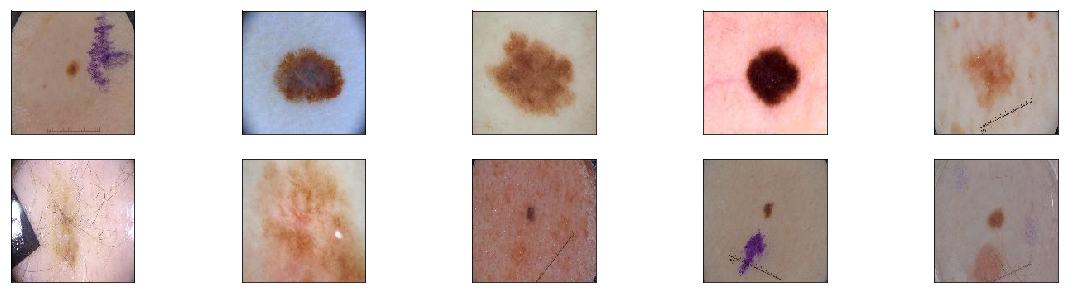

In [2]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def visualize_img(img_path, ax):
    img = cv2.imread(img_path)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))    
    
fig = plt.figure(figsize=(20,5))
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    visualize_img(train_files[i], ax)

### 4. Define a Model Architecture

In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(150,150,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 16)      208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 18, 18, 64)        0         
__________

### 5. Compile the Model

In [4]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'rmsprop',
              metrics = ['accuracy'])

### 6. Train our model

In [5]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)

batch_size = 16

train_generator = datagen.flow_from_directory(train_data_dir_resized,
                                              target_size=(150,150),
                                              batch_size=batch_size)

validation_generator = datagen.flow_from_directory(valid_data_dir_resized,
                                                   target_size=(150,150),
                                                   batch_size=batch_size)


Found 1726 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


In [8]:
from keras.callbacks import ModelCheckpoint

batch_size = 16
epochs = 50

checkpointer = ModelCheckpoint('derm.weights.best.hdf5',
                               verbose=1,
                               save_best_only=True)

model.fit_generator(train_generator,
                    steps_per_epoch=len(train_files) // batch_size,
                    epochs=epochs,
                    verbose=2,
                    callbacks=[checkpointer],
                    validation_data=validation_generator,
                    validation_steps=len(valid_files) // batch_size)


Epoch 1/50
 - 36s - loss: 0.7038 - acc: 0.7901 - val_loss: 1.0788 - val_acc: 0.5208

Epoch 00001: val_loss improved from inf to 1.07879, saving model to derm.weights.best.hdf5
Epoch 2/50
 - 37s - loss: 0.6302 - acc: 0.7963 - val_loss: 0.9544 - val_acc: 0.5149

Epoch 00002: val_loss improved from 1.07879 to 0.95436, saving model to derm.weights.best.hdf5
Epoch 3/50
 - 33s - loss: 0.5927 - acc: 0.7953 - val_loss: 1.3112 - val_acc: 0.5373

Epoch 00003: val_loss did not improve
Epoch 4/50
 - 35s - loss: 0.5855 - acc: 0.8047 - val_loss: 1.0997 - val_acc: 0.5597

Epoch 00004: val_loss did not improve
Epoch 5/50
 - 37s - loss: 0.5600 - acc: 0.8064 - val_loss: 1.0909 - val_acc: 0.5970

Epoch 00005: val_loss did not improve
Epoch 6/50
 - 39s - loss: 0.5407 - acc: 0.8235 - val_loss: 1.0347 - val_acc: 0.6194

Epoch 00006: val_loss did not improve
Epoch 7/50
 - 38s - loss: 0.5620 - acc: 0.8198 - val_loss: 0.9434 - val_acc: 0.6194

Epoch 00007: val_loss improved from 0.95436 to 0.94345, saving mode

### 7. Load The Model With The Best Validation Accuracy

In [6]:
model.load_weights('derm.weights.best.hdf5')

### 8. Testing

In [7]:
test_generator = datagen.flow_from_directory(test_data_dir_resized,
                                             target_size=(150,150),
                                             batch_size=batch_size,
                                             shuffle = False)
test_images = test_generator.filenames
x = model.predict_generator(test_generator)
   

Found 600 images belonging to 3 classes.


### 9. Export Predictions to a CSV File

In [8]:
import csv

i = 0
results = []
while i < len(test_images):
    max_value = max(x[i][0], x[i][1], x[i][2])
    if max_value == x[i][0]:
        results.append([1,0])
    if max_value == x[i][1]:
        results.append([0,0])
    if max_value == x[i][2]:
        results.append([0,1])
    i +=1
    
myData = [['Id', 'task_1', 'task_2']]
myFile = open('predictions.csv', 'a', newline='')  
with myFile:
    writer = csv.writer(myFile)
    writer.writerows(myData)    
    
i = 0
while i < len(test_images):
    im_name = 'data/test/' + test_images[i]
    myData = [[im_name.replace("\\", '/'), results[i][0], results[i][1]]]
    myFile = open('predictions.csv', 'a', newline='')  
    with myFile:  
        writer = csv.writer(myFile)
        writer.writerows(myData)
    i +=1
    
print ('Predictions exported to file: predictions.csv')

Predictions exported to file: predictions.csv


### 10. Compare Predictions With the Labels

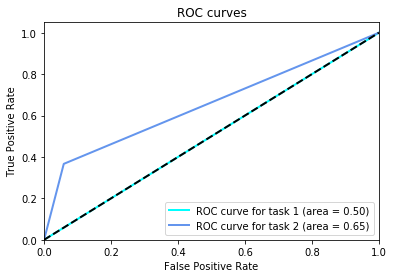

Category 1 Score: 0.500
Category 2 Score: 0.654
Category 3 Score: 0.577


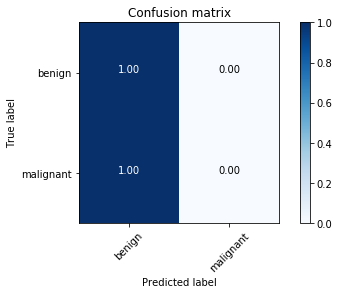

In [10]:
# Compare predicted output (predictions.csv) with actual output (ground_truth.csv)
%run -i get_results.py predictions.csv
